# Apply AI Superresolution to video - Train MWCNN from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors - tried, but no improvement.
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.

UNET results
- Some sharpening but not drastic.  Not better than VDSR
- Used 2x GPU mem than VDSR

To Try
- UNET or VDSR with MAXout nonlinear function.  Try different activation functions (mish,etc).
- consistency error measure like fastai superres
- provide input,target  pairs with no fuzziness in the training set.
- Train exclusively on very sharp  images (DIV2K)
- Predict focus as a segmentation in addition to enhancing
- have 3 channel inputs (RGB or ??) and then have 1 channel output
- provide frame-1,frame,frame+1 to predict frame
- opposite of bottleneck - input resolution -> high res -> input res blocks.
- combo of UNET and VDSR
- attention?
- combo of perception and mse measure
- add validation set
- sort dataset into hard cases and easy cases, making cases harder with time.  (train on easy cases first, then fine tune with harder cases)
- make the camera model version of the data loader







## Share results
- put out an example on youtube to allow comparison


# Project Documentation

In [1]:

from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "MWCNN"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train MWCNN.ipynb


In [4]:
nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution train MWCNN.ipynb
/media/SSD/superres/Results/Superresolution train MWCNN


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale,ToPILImage

import random
#from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


#import sys
#sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [10]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [11]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [12]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [13]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [14]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [15]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [16]:
def tophat2D(r):
    
    d=2*int(r)+1
    Y, X = np.ogrid[:d, :d]
    c=int(r)
    k = (np.sqrt((X-c)**2 +  (Y-c)**2) <= r)*1 
    
    return k/k.sum()

    
    

In [17]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [18]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, tophat2D(rand_scale_factor))
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [19]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        
        k=tophat2D(int(self.kernel_size)/2.0)
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [20]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [21]:
tophat2D(2)

array([[0.        , 0.        , 0.07692308, 0.        , 0.        ],
       [0.        , 0.07692308, 0.07692308, 0.07692308, 0.        ],
       [0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308],
       [0.        , 0.07692308, 0.07692308, 0.07692308, 0.        ],
       [0.        , 0.        , 0.07692308, 0.        , 0.        ]])

In [22]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = tophat2D(int(rand_kernel)/2.0)
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = tophat2D(int(rand_kernel)/2.0)
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


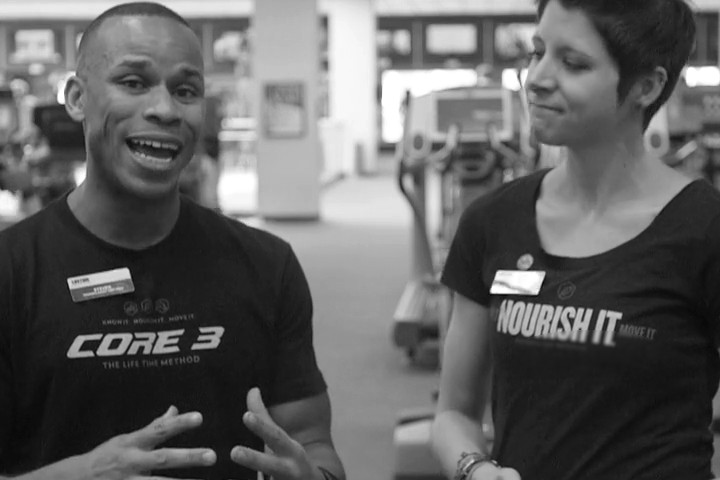

In [25]:
#test the CropRescale transform
im=load_frame(instances[10])
im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,10), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [26]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.001, 1),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [28]:
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 2 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
#crop_size = (256,256)
kernel_range=(1,10)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [29]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [30]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [31]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [32]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([2, 1, 480, 720])


IndexError: index 2 is out of bounds for axis 0 with size 2

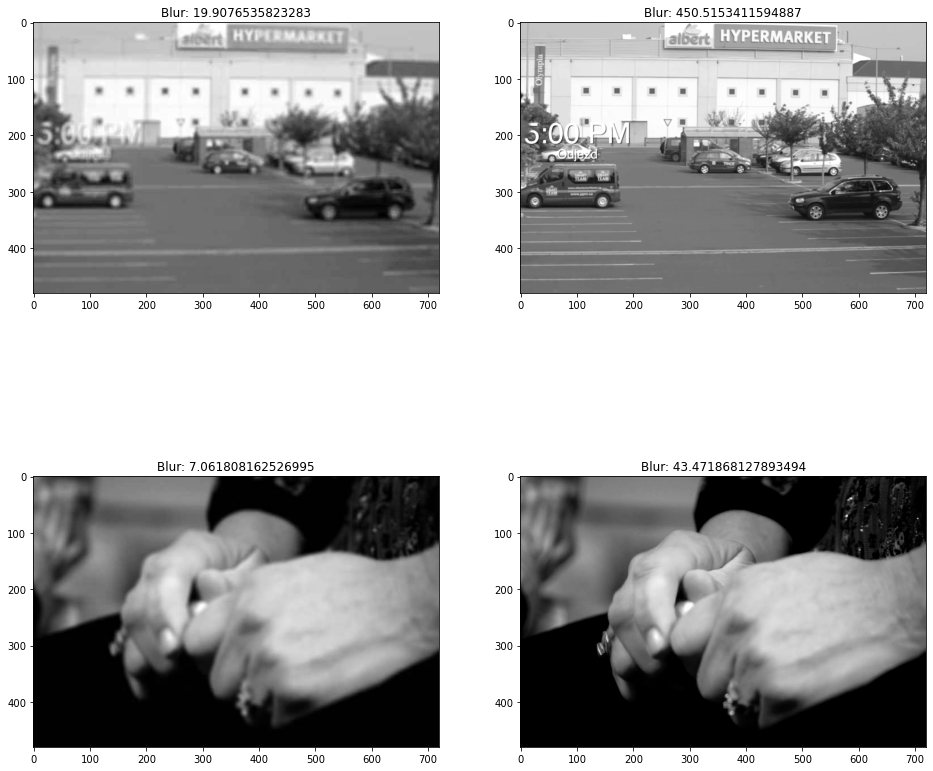

In [33]:
show_batch(training_data_loader,size =8)

# MWCNN
https://github.com/lpj-github-io/MWCNNv2/blob/master/MWCNN_code/model/mwcnn.py

In [ ]:
class Maxout(nn.Module):
    def __init__(self, pool_size):
        super().__init__()
        self._pool_size = pool_size

    def forward(self, x):
        assert x.shape[1] % self._pool_size == 0, \
            'Wrong input last dim size ({}) for Maxout({})'.format(x.shape[1], self._pool_size)
        m, i = x.view(*x.shape[:1], x.shape[1] // self._pool_size, self._pool_size, *x.shape[2:]).max(2)
        return m

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.autograd import Function

class Maxout(Function):
  # Note that both forward and backward are @staticmethods
  @staticmethod
  # bias is an optional argument
  def forward(ctx, input):
    x = input
    max_out=4    #Maxout Parameter
    kernels = x.shape[1]  # to get how many kernels/output
    feature_maps = int(kernels / max_out)
    out_shape = (x.shape[0], feature_maps, max_out, x.shape[2], x.shape[3])
    x= x.view(out_shape)
    y, indices = torch.max(x[:, :, :], 2)
    ctx.save_for_backward(input)
    ctx.indices=indices
    ctx.max_out=max_out
    return y

# This function has only a single output, so it gets only one gradient
@staticmethod
def backward(ctx, grad_output):
  input1,indices,max_out= ctx.saved_variables[0],Variable(ctx.indices),ctx.max_out
  input=input1.clone()
  for i in range(max_out):
      a0=indices==i
      input[:,i:input.data.shape[1]:max_out]=a0.float()*grad_output


  return input


In [38]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

def default_conv(in_channels, out_channels, kernel_size, bias=True, dilation=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2)+dilation-1, bias=bias, dilation=dilation)


def default_conv1(in_channels, out_channels, kernel_size, bias=True, groups=3):
    return nn.Conv2d(
        in_channels,out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, groups=groups)

#def shuffle_channel()

def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.size()

    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups,
               channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x

def pixel_down_shuffle(x, downsacale_factor):
    batchsize, num_channels, height, width = x.size()

    out_height = height // downsacale_factor
    out_width = width // downsacale_factor
    input_view = x.contiguous().view(batchsize, num_channels, out_height, downsacale_factor, out_width,
                                     downsacale_factor)

    num_channels *= downsacale_factor ** 2
    unshuffle_out = input_view.permute(0,1,3,5,2,4).contiguous()

    return unshuffle_out.view(batchsize, num_channels, out_height, out_width)



def sp_init(x):

    x01 = x[:, :, 0::2, :]
    x02 = x[:, :, 1::2, :]
    x_LL = x01[:, :, :, 0::2]
    x_HL = x02[:, :, :, 0::2]
    x_LH = x01[:, :, :, 1::2]
    x_HH = x02[:, :, :, 1::2]


    return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)

def dwt_init(x):

    x01 = x[:, :, 0::2, :] / 2
    x02 = x[:, :, 1::2, :] / 2
    x1 = x01[:, :, :, 0::2]
    x2 = x02[:, :, :, 0::2]
    x3 = x01[:, :, :, 1::2]
    x4 = x02[:, :, :, 1::2]
    x_LL = x1 + x2 + x3 + x4
    x_HL = -x1 - x2 + x3 + x4
    x_LH = -x1 + x2 - x3 + x4
    x_HH = x1 - x2 - x3 + x4

    return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)

def iwt_init(x):
    r = 2
    in_batch, in_channel, in_height, in_width = x.size()
    #print([in_batch, in_channel, in_height, in_width])
    out_batch, out_channel, out_height, out_width = in_batch, int(
        in_channel / (r ** 2)), r * in_height, r * in_width
    x1 = x[:, 0:out_channel, :, :] / 2
    x2 = x[:, out_channel:out_channel * 2, :, :] / 2
    x3 = x[:, out_channel * 2:out_channel * 3, :, :] / 2
    x4 = x[:, out_channel * 3:out_channel * 4, :, :] / 2
    

    h = torch.zeros([out_batch, out_channel, out_height, out_width]).float().cuda()

    h[:, :, 0::2, 0::2] = x1 - x2 - x3 + x4
    h[:, :, 1::2, 0::2] = x1 - x2 + x3 - x4
    h[:, :, 0::2, 1::2] = x1 + x2 - x3 - x4
    h[:, :, 1::2, 1::2] = x1 + x2 + x3 + x4

    return h

class Channel_Shuffle(nn.Module):
    def __init__(self, conv_groups):
        super(Channel_Shuffle, self).__init__()
        self.conv_groups = conv_groups
        self.requires_grad = False

    def forward(self, x):
        return channel_shuffle(x, self.conv_groups)

class SP(nn.Module):
    def __init__(self):
        super(SP, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return sp_init(x)

class Pixel_Down_Shuffle(nn.Module):
    def __init__(self):
        super(Pixel_Down_Shuffle, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return pixel_down_shuffle(x, 2)

class DWT(nn.Module):
    def __init__(self):
        super(DWT, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return dwt_init(x)

class IWT(nn.Module):
    def __init__(self):
        super(IWT, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return iwt_init(x)


class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.weight.data.div_(std.view(3, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False
        if sign==-1:
            self.create_graph = False
            self.volatile = True
class MeanShift2(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift2, self).__init__(4, 4, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(4).view(4, 4, 1, 1)
        self.weight.data.div_(std.view(4, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False
        if sign==-1:
            self.volatile = True

class BasicBlock(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=False, act=nn.ReLU(True)):

        m = [nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2), stride=stride, bias=bias)
        ]
        if bn: m.append(nn.BatchNorm2d(out_channels))
        if act is not None: m.append(act)
        super(BasicBlock, self).__init__(*m)

class BBlock(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(BBlock, self).__init__()
        m = []
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x).mul(self.res_scale)
        return x

class DBlock_com(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_com, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=3))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_inv(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_inv, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=3))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_com1(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_com1, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=1))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_inv1(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_inv1, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=1))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_com2(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_com2, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class DBlock_inv2(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DBlock_inv2, self).__init__()
        m = []

        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=2))
        if bn: m.append(nn.BatchNorm2d(out_channels, eps=1e-4, momentum=0.95))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

class ShuffleBlock(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1,conv_groups=1):

        super(ShuffleBlock, self).__init__()
        m = []
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias))
        m.append(Channel_Shuffle(conv_groups))
        if bn: m.append(nn.BatchNorm2d(out_channels))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x).mul(self.res_scale)
        return x


class DWBlock(nn.Module):
    def __init__(
        self, conv, conv1, in_channels, out_channels, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(DWBlock, self).__init__()
        m = []
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias))
        if bn: m.append(nn.BatchNorm2d(out_channels))
        m.append(act)

        m.append(conv1(in_channels, out_channels, 1, bias=bias))
        if bn: m.append(nn.BatchNorm2d(out_channels))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x).mul(self.res_scale)
        return x

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Block(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(Block, self).__init__()
        m = []
        for i in range(4):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        # res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

In [39]:
import torch
import torch.nn as nn
import scipy.io as sio

def make_model(args, parent=False):
    return MWCNN(args)

class MWCNN(nn.Module):
    def __init__(self, args, conv=default_conv):
        super(MWCNN, self).__init__()
        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3
        self.scale_idx = 0
        nColor = args.n_colors

        act = nn.ReLU(True)

        self.DWT = DWT()
        self.IWT = IWT()

        n = 1
        m_head = [BBlock(conv, nColor, n_feats, kernel_size, act=act)]
        d_l0 = []
        d_l0.append(DBlock_com1(conv, n_feats, n_feats, kernel_size, act=act, bn=False))


        d_l1 = [BBlock(conv, n_feats * 4, n_feats * 2, kernel_size, act=act, bn=False)]
        d_l1.append(DBlock_com1(conv, n_feats * 2, n_feats * 2, kernel_size, act=act, bn=False))

        d_l2 = []
        d_l2.append(BBlock(conv, n_feats * 8, n_feats * 4, kernel_size, act=act, bn=False))
        d_l2.append(DBlock_com1(conv, n_feats * 4, n_feats * 4, kernel_size, act=act, bn=False))
        pro_l3 = []
        pro_l3.append(BBlock(conv, n_feats * 16, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(DBlock_com(conv, n_feats * 8, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(DBlock_inv(conv, n_feats * 8, n_feats * 8, kernel_size, act=act, bn=False))
        pro_l3.append(BBlock(conv, n_feats * 8, n_feats * 16, kernel_size, act=act, bn=False))

        i_l2 = [DBlock_inv1(conv, n_feats * 4, n_feats * 4, kernel_size, act=act, bn=False)]
        i_l2.append(BBlock(conv, n_feats * 4, n_feats * 8, kernel_size, act=act, bn=False))

        i_l1 = [DBlock_inv1(conv, n_feats * 2, n_feats * 2, kernel_size, act=act, bn=False)]
        i_l1.append(BBlock(conv, n_feats * 2, n_feats * 4, kernel_size, act=act, bn=False))

        i_l0 = [DBlock_inv1(conv, n_feats, n_feats, kernel_size, act=act, bn=False)]

        m_tail = [conv(n_feats, nColor, kernel_size)]

        self.head = nn.Sequential(*m_head)
        self.d_l2 = nn.Sequential(*d_l2)
        self.d_l1 = nn.Sequential(*d_l1)
        self.d_l0 = nn.Sequential(*d_l0)
        self.pro_l3 = nn.Sequential(*pro_l3)
        self.i_l2 = nn.Sequential(*i_l2)
        self.i_l1 = nn.Sequential(*i_l1)
        self.i_l0 = nn.Sequential(*i_l0)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        x0 = self.d_l0(self.head(x))
        x1 = self.d_l1(self.DWT(x0))
        x2 = self.d_l2(self.DWT(x1))
        x_ = self.IWT(self.pro_l3(self.DWT(x2))) + x2
        x_ = self.IWT(self.i_l2(x_)) + x1
        x_ = self.IWT(self.i_l1(x_)) + x0
        x = self.tail(self.i_l0(x_)) + x

        return x

    def set_scale(self, scale_idx):
        self.scale_idx = scale_idx

# build the model

In [40]:
from types import SimpleNamespace

args = SimpleNamespace()


args.n_resblocks = 20 # was 20
args.n_feats = 64
args.n_colors = 1

#args.n_resgroups = 5 # was 10
#args.reduction = 16
#args.scale = (1,0)
#args.rgb_range = 255

#args.res_scale = 1

In [41]:
model = MWCNN(args)
model.cuda()

MWCNN(
  (DWT): DWT()
  (IWT): IWT()
  (head): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (d_l2): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DBlock_com1(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (d_l1): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DBlock_com1(
      (body): Sequential(
        (0): Conv2d(128, 128,

In [42]:
num_pixels = crop_size[0] * crop_size[1]

In [43]:
def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

In [44]:
class Pixel_Loss(torch.nn.Module):
    
    def __init__(self,num_pixels):
        super(Pixel_Loss,self).__init__()
        self.lossfn = nn.MSELoss(reduction = 'mean')
        
        self.percep_loss_fn = lpips.LPIPS(net='alex').cuda()


        self.num_pixels = num_pixels
    #def forward(self,x,y):
        
     #   return self.num_pixels*(self.lossfn.forward(x,y))
    
    
    def forward(self,x,y):
        
        totloss = torch.mean(self.percep_loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        #print("perceptual:",totloss)
        
        totloss.add_(100 * self.lossfn.forward(x,y))
        #print("total:",totloss)
        
        return totloss


In [45]:
criterion = Pixel_Loss(num_pixels)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [46]:
init_lr = .001
lr_step = 3
gradient_clip = 0.4
epochs = 12

In [47]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)


In [48]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [49]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [50]:
def save_checkpoint(experiment, model, epoch):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [51]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler
#import kornia


In [52]:
from torch.optim.swa_utils import AveragedModel
swa_model = torch.optim.swa_utils.AveragedModel(model)

In [53]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        
        target = target.cuda()
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            loss = criterion(output, target)
            
        
        
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        if epoch>1:
            swa_model.update_parameters(model)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
   
    print("Epoch Loss:", cum_loss2/ct2)        

In [54]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch)

Start Time: 2020-10-20 20:34:18.950591
Epoch = 1, lr = 0.001
===> Time: 2020-10-20 20:34:26.602233 Epoch[1](10/3172): LR: 0.001 : Loss: 0.3793945312
===> Time: 2020-10-20 20:34:34.069779 Epoch[1](20/3172): LR: 0.001 : Loss: 0.4553222656
===> Time: 2020-10-20 20:34:41.412238 Epoch[1](30/3172): LR: 0.001 : Loss: 0.2032470703
===> Time: 2020-10-20 20:34:48.634581 Epoch[1](40/3172): LR: 0.001 : Loss: 0.2327880859
===> Time: 2020-10-20 20:34:56.123001 Epoch[1](50/3172): LR: 0.001 : Loss: 0.5961914062
===> Time: 2020-10-20 20:35:03.500346 Epoch[1](60/3172): LR: 0.001 : Loss: 0.2519531250
===> Time: 2020-10-20 20:35:11.005007 Epoch[1](70/3172): LR: 0.001 : Loss: 0.3059082031
===> Time: 2020-10-20 20:35:18.442732 Epoch[1](80/3172): LR: 0.001 : Loss: 0.4667968750
===> Time: 2020-10-20 20:35:25.926048 Epoch[1](90/3172): LR: 0.001 : Loss: 0.4565429688
===> Time: 2020-10-20 20:35:33.363594 Epoch[1](100/3172): LR: 0.001 : Loss: 0.7592773438
===> Time: 2020-10-20 20:35:40.858620 Epoch[1](110/3172): 

===> Time: 2020-10-20 20:45:56.224104 Epoch[1](930/3172): LR: 0.001 : Loss: 0.2871093750
===> Time: 2020-10-20 20:46:03.647734 Epoch[1](940/3172): LR: 0.001 : Loss: 0.2639160156
===> Time: 2020-10-20 20:46:11.169288 Epoch[1](950/3172): LR: 0.001 : Loss: 0.2631835938
===> Time: 2020-10-20 20:46:18.695146 Epoch[1](960/3172): LR: 0.001 : Loss: 0.2834472656
===> Time: 2020-10-20 20:46:25.986709 Epoch[1](970/3172): LR: 0.001 : Loss: 0.3808593750
===> Time: 2020-10-20 20:46:33.395326 Epoch[1](980/3172): LR: 0.001 : Loss: 0.2044677734
===> Time: 2020-10-20 20:46:40.952598 Epoch[1](990/3172): LR: 0.001 : Loss: 0.2763671875
===> Time: 2020-10-20 20:46:48.532016 Epoch[1](1000/3172): LR: 0.001 : Loss: 0.2753906250
===> Time: 2020-10-20 20:46:56.054788 Epoch[1](1010/3172): LR: 0.001 : Loss: 0.2397460938
===> Time: 2020-10-20 20:47:03.627622 Epoch[1](1020/3172): LR: 0.001 : Loss: 0.2050781250
===> Time: 2020-10-20 20:47:11.182387 Epoch[1](1030/3172): LR: 0.001 : Loss: 0.2357177734
===> Time: 2020-1

===> Time: 2020-10-20 20:57:15.380172 Epoch[1](1850/3172): LR: 0.001 : Loss: 0.2763671875
===> Time: 2020-10-20 20:57:22.671723 Epoch[1](1860/3172): LR: 0.001 : Loss: 0.2426757812
===> Time: 2020-10-20 20:57:29.893679 Epoch[1](1870/3172): LR: 0.001 : Loss: 0.2396240234
===> Time: 2020-10-20 20:57:37.295121 Epoch[1](1880/3172): LR: 0.001 : Loss: 0.2897949219
===> Time: 2020-10-20 20:57:44.504184 Epoch[1](1890/3172): LR: 0.001 : Loss: 0.2484130859
===> Time: 2020-10-20 20:57:51.789486 Epoch[1](1900/3172): LR: 0.001 : Loss: 0.4890136719
===> Time: 2020-10-20 20:57:59.167178 Epoch[1](1910/3172): LR: 0.001 : Loss: 0.2753906250
===> Time: 2020-10-20 20:58:06.397048 Epoch[1](1920/3172): LR: 0.001 : Loss: 0.2158203125
===> Time: 2020-10-20 20:58:13.790820 Epoch[1](1930/3172): LR: 0.001 : Loss: 0.3757324219
===> Time: 2020-10-20 20:58:20.962382 Epoch[1](1940/3172): LR: 0.001 : Loss: 0.2819824219
===> Time: 2020-10-20 20:58:28.330352 Epoch[1](1950/3172): LR: 0.001 : Loss: 0.2402343750
===> Time:

===> Time: 2020-10-20 21:08:26.500197 Epoch[1](2770/3172): LR: 0.001 : Loss: 0.3395996094
===> Time: 2020-10-20 21:08:33.954214 Epoch[1](2780/3172): LR: 0.001 : Loss: 0.4707031250
===> Time: 2020-10-20 21:08:41.189164 Epoch[1](2790/3172): LR: 0.001 : Loss: 0.2998046875
===> Time: 2020-10-20 21:08:48.372473 Epoch[1](2800/3172): LR: 0.001 : Loss: 0.5014648438
===> Time: 2020-10-20 21:08:55.544519 Epoch[1](2810/3172): LR: 0.001 : Loss: 0.5332031250
===> Time: 2020-10-20 21:09:02.753236 Epoch[1](2820/3172): LR: 0.001 : Loss: 0.2788085938
===> Time: 2020-10-20 21:09:10.003315 Epoch[1](2830/3172): LR: 0.001 : Loss: 0.2106933594
===> Time: 2020-10-20 21:09:17.238707 Epoch[1](2840/3172): LR: 0.001 : Loss: 0.2034912109
===> Time: 2020-10-20 21:09:24.569929 Epoch[1](2850/3172): LR: 0.001 : Loss: 0.3928222656
===> Time: 2020-10-20 21:09:31.743708 Epoch[1](2860/3172): LR: 0.001 : Loss: 0.2454833984
===> Time: 2020-10-20 21:09:38.984670 Epoch[1](2870/3172): LR: 0.001 : Loss: 0.3439941406
===> Time:

===> Time: 2020-10-20 21:19:27.208572 Epoch[2](500/3172): LR: 0.001 : Loss: 0.3452148438
===> Time: 2020-10-20 21:19:34.716706 Epoch[2](510/3172): LR: 0.001 : Loss: 0.4042968750
===> Time: 2020-10-20 21:19:42.136441 Epoch[2](520/3172): LR: 0.001 : Loss: 0.2109375000
===> Time: 2020-10-20 21:19:49.503469 Epoch[2](530/3172): LR: 0.001 : Loss: 0.3247070312
===> Time: 2020-10-20 21:19:56.880806 Epoch[2](540/3172): LR: 0.001 : Loss: 0.4311523438
===> Time: 2020-10-20 21:20:04.143585 Epoch[2](550/3172): LR: 0.001 : Loss: 0.2409667969
===> Time: 2020-10-20 21:20:11.629621 Epoch[2](560/3172): LR: 0.001 : Loss: 0.2075195312
===> Time: 2020-10-20 21:20:18.904309 Epoch[2](570/3172): LR: 0.001 : Loss: 0.2841796875
===> Time: 2020-10-20 21:20:26.351651 Epoch[2](580/3172): LR: 0.001 : Loss: 0.4267578125
===> Time: 2020-10-20 21:20:33.890973 Epoch[2](590/3172): LR: 0.001 : Loss: 0.2019042969
===> Time: 2020-10-20 21:20:41.219028 Epoch[2](600/3172): LR: 0.001 : Loss: 0.3103027344
===> Time: 2020-10-20

===> Time: 2020-10-20 21:30:46.372816 Epoch[2](1420/3172): LR: 0.001 : Loss: 0.2012939453
===> Time: 2020-10-20 21:30:53.698817 Epoch[2](1430/3172): LR: 0.001 : Loss: 0.2327880859
===> Time: 2020-10-20 21:31:00.960655 Epoch[2](1440/3172): LR: 0.001 : Loss: 0.2487792969
===> Time: 2020-10-20 21:31:08.422470 Epoch[2](1450/3172): LR: 0.001 : Loss: 0.3332519531
===> Time: 2020-10-20 21:31:15.838377 Epoch[2](1460/3172): LR: 0.001 : Loss: 0.2343750000
===> Time: 2020-10-20 21:31:23.144248 Epoch[2](1470/3172): LR: 0.001 : Loss: 0.2937011719
===> Time: 2020-10-20 21:31:30.473355 Epoch[2](1480/3172): LR: 0.001 : Loss: 0.2912597656
===> Time: 2020-10-20 21:31:37.918093 Epoch[2](1490/3172): LR: 0.001 : Loss: 0.2841796875
===> Time: 2020-10-20 21:31:45.310444 Epoch[2](1500/3172): LR: 0.001 : Loss: 0.3769531250
===> Time: 2020-10-20 21:31:52.723983 Epoch[2](1510/3172): LR: 0.001 : Loss: 0.2563476562
===> Time: 2020-10-20 21:32:00.123893 Epoch[2](1520/3172): LR: 0.001 : Loss: 0.7998046875
===> Time:

===> Time: 2020-10-20 21:42:04.289220 Epoch[2](2340/3172): LR: 0.001 : Loss: 0.2353515625
===> Time: 2020-10-20 21:42:11.816694 Epoch[2](2350/3172): LR: 0.001 : Loss: 0.4916992188
===> Time: 2020-10-20 21:42:19.204040 Epoch[2](2360/3172): LR: 0.001 : Loss: 0.1740722656
===> Time: 2020-10-20 21:42:26.586784 Epoch[2](2370/3172): LR: 0.001 : Loss: 0.2614746094
===> Time: 2020-10-20 21:42:33.935816 Epoch[2](2380/3172): LR: 0.001 : Loss: 0.3378906250
===> Time: 2020-10-20 21:42:41.283160 Epoch[2](2390/3172): LR: 0.001 : Loss: 0.4619140625
===> Time: 2020-10-20 21:42:48.602429 Epoch[2](2400/3172): LR: 0.001 : Loss: 0.1982421875
===> Time: 2020-10-20 21:42:56.020249 Epoch[2](2410/3172): LR: 0.001 : Loss: 0.2426757812
===> Time: 2020-10-20 21:43:03.445903 Epoch[2](2420/3172): LR: 0.001 : Loss: 0.2827148438
===> Time: 2020-10-20 21:43:10.843651 Epoch[2](2430/3172): LR: 0.001 : Loss: 0.3630371094
===> Time: 2020-10-20 21:43:18.096490 Epoch[2](2440/3172): LR: 0.001 : Loss: 0.3293457031
===> Time:

===> Time: 2020-10-20 21:53:01.536491 Epoch[3](60/3172): LR: 0.001 : Loss: 0.9545898438
===> Time: 2020-10-20 21:53:08.963808 Epoch[3](70/3172): LR: 0.001 : Loss: 0.2354736328
===> Time: 2020-10-20 21:53:16.414784 Epoch[3](80/3172): LR: 0.001 : Loss: 1.0761718750
===> Time: 2020-10-20 21:53:23.776597 Epoch[3](90/3172): LR: 0.001 : Loss: 0.3916015625
===> Time: 2020-10-20 21:53:31.176749 Epoch[3](100/3172): LR: 0.001 : Loss: 0.2055664062
===> Time: 2020-10-20 21:53:38.517260 Epoch[3](110/3172): LR: 0.001 : Loss: 0.4580078125
===> Time: 2020-10-20 21:53:45.984775 Epoch[3](120/3172): LR: 0.001 : Loss: 0.1672363281
===> Time: 2020-10-20 21:53:53.367759 Epoch[3](130/3172): LR: 0.001 : Loss: 0.4160156250
===> Time: 2020-10-20 21:54:00.714860 Epoch[3](140/3172): LR: 0.001 : Loss: 0.2200927734
===> Time: 2020-10-20 21:54:08.132706 Epoch[3](150/3172): LR: 0.001 : Loss: 0.2590332031
===> Time: 2020-10-20 21:54:15.427610 Epoch[3](160/3172): LR: 0.001 : Loss: 0.5629882812
===> Time: 2020-10-20 21:

===> Time: 2020-10-20 22:04:27.278968 Epoch[3](990/3172): LR: 0.001 : Loss: 0.4404296875
===> Time: 2020-10-20 22:04:34.647907 Epoch[3](1000/3172): LR: 0.001 : Loss: 0.2419433594
===> Time: 2020-10-20 22:04:41.855120 Epoch[3](1010/3172): LR: 0.001 : Loss: 0.3710937500
===> Time: 2020-10-20 22:04:49.194498 Epoch[3](1020/3172): LR: 0.001 : Loss: 0.2133789062
===> Time: 2020-10-20 22:04:56.402758 Epoch[3](1030/3172): LR: 0.001 : Loss: 0.2286376953
===> Time: 2020-10-20 22:05:03.856768 Epoch[3](1040/3172): LR: 0.001 : Loss: 0.2097167969
===> Time: 2020-10-20 22:05:11.125020 Epoch[3](1050/3172): LR: 0.001 : Loss: 0.4436035156
===> Time: 2020-10-20 22:05:18.414758 Epoch[3](1060/3172): LR: 0.001 : Loss: 0.6660156250
===> Time: 2020-10-20 22:05:25.872348 Epoch[3](1070/3172): LR: 0.001 : Loss: 0.3017578125
===> Time: 2020-10-20 22:05:33.150935 Epoch[3](1080/3172): LR: 0.001 : Loss: 0.1630859375
===> Time: 2020-10-20 22:05:40.512953 Epoch[3](1090/3172): LR: 0.001 : Loss: 0.2658691406
===> Time: 

===> Time: 2020-10-20 22:15:44.589173 Epoch[3](1910/3172): LR: 0.001 : Loss: 0.3049316406
===> Time: 2020-10-20 22:15:52.040629 Epoch[3](1920/3172): LR: 0.001 : Loss: 0.2011718750
===> Time: 2020-10-20 22:15:59.457294 Epoch[3](1930/3172): LR: 0.001 : Loss: 0.2315673828
===> Time: 2020-10-20 22:16:06.762884 Epoch[3](1940/3172): LR: 0.001 : Loss: 0.2768554688
===> Time: 2020-10-20 22:16:14.104202 Epoch[3](1950/3172): LR: 0.001 : Loss: 0.2396240234
===> Time: 2020-10-20 22:16:21.408863 Epoch[3](1960/3172): LR: 0.001 : Loss: 0.2384033203
===> Time: 2020-10-20 22:16:28.723575 Epoch[3](1970/3172): LR: 0.001 : Loss: 0.1746826172
===> Time: 2020-10-20 22:16:35.977141 Epoch[3](1980/3172): LR: 0.001 : Loss: 0.5180664062
===> Time: 2020-10-20 22:16:43.288524 Epoch[3](1990/3172): LR: 0.001 : Loss: 0.2539062500
===> Time: 2020-10-20 22:16:50.697118 Epoch[3](2000/3172): LR: 0.001 : Loss: 0.3400878906
===> Time: 2020-10-20 22:16:58.101898 Epoch[3](2010/3172): LR: 0.001 : Loss: 0.2687988281
===> Time:

===> Time: 2020-10-20 22:27:02.655408 Epoch[3](2830/3172): LR: 0.001 : Loss: 0.1872558594
===> Time: 2020-10-20 22:27:09.989576 Epoch[3](2840/3172): LR: 0.001 : Loss: 0.2907714844
===> Time: 2020-10-20 22:27:17.406730 Epoch[3](2850/3172): LR: 0.001 : Loss: 0.2441406250
===> Time: 2020-10-20 22:27:24.875171 Epoch[3](2860/3172): LR: 0.001 : Loss: 0.3547363281
===> Time: 2020-10-20 22:27:32.338636 Epoch[3](2870/3172): LR: 0.001 : Loss: 0.3608398438
===> Time: 2020-10-20 22:27:39.637670 Epoch[3](2880/3172): LR: 0.001 : Loss: 0.2142333984
===> Time: 2020-10-20 22:27:47.027451 Epoch[3](2890/3172): LR: 0.001 : Loss: 0.3767089844
===> Time: 2020-10-20 22:27:54.364726 Epoch[3](2900/3172): LR: 0.001 : Loss: 0.2922363281
===> Time: 2020-10-20 22:28:01.853847 Epoch[3](2910/3172): LR: 0.001 : Loss: 0.2441406250
===> Time: 2020-10-20 22:28:09.172531 Epoch[3](2920/3172): LR: 0.001 : Loss: 0.4155273438
===> Time: 2020-10-20 22:28:16.541379 Epoch[3](2930/3172): LR: 0.001 : Loss: 0.2353515625
===> Time:

===> Time: 2020-10-20 22:37:00.453185 Epoch[4](470/3172): LR: 0.00031622776601683794 : Loss: 0.3266601562
===> Time: 2020-10-20 22:37:07.859933 Epoch[4](480/3172): LR: 0.00031622776601683794 : Loss: 0.7114257812
===> Time: 2020-10-20 22:37:15.195911 Epoch[4](490/3172): LR: 0.00031622776601683794 : Loss: 0.3393554688
===> Time: 2020-10-20 22:37:22.760728 Epoch[4](500/3172): LR: 0.00031622776601683794 : Loss: 0.3041992188
===> Time: 2020-10-20 22:37:30.131077 Epoch[4](510/3172): LR: 0.00031622776601683794 : Loss: 0.2836914062
===> Time: 2020-10-20 22:37:37.418064 Epoch[4](520/3172): LR: 0.00031622776601683794 : Loss: 0.2829589844
===> Time: 2020-10-20 22:37:44.838799 Epoch[4](530/3172): LR: 0.00031622776601683794 : Loss: 0.2065429688
===> Time: 2020-10-20 22:37:52.208196 Epoch[4](540/3172): LR: 0.00031622776601683794 : Loss: 0.1660156250
===> Time: 2020-10-20 22:37:59.633328 Epoch[4](550/3172): LR: 0.00031622776601683794 : Loss: 0.4116210938
===> Time: 2020-10-20 22:38:06.874322 Epoch[4]

===> Time: 2020-10-20 22:46:35.248996 Epoch[4](1250/3172): LR: 0.00031622776601683794 : Loss: 0.3005371094
===> Time: 2020-10-20 22:46:42.683856 Epoch[4](1260/3172): LR: 0.00031622776601683794 : Loss: 0.2863769531
===> Time: 2020-10-20 22:46:50.075474 Epoch[4](1270/3172): LR: 0.00031622776601683794 : Loss: 0.3593750000
===> Time: 2020-10-20 22:46:57.563645 Epoch[4](1280/3172): LR: 0.00031622776601683794 : Loss: 0.2795410156
===> Time: 2020-10-20 22:47:04.919823 Epoch[4](1290/3172): LR: 0.00031622776601683794 : Loss: 0.8208007812
===> Time: 2020-10-20 22:47:12.316007 Epoch[4](1300/3172): LR: 0.00031622776601683794 : Loss: 0.2333984375
===> Time: 2020-10-20 22:47:19.697026 Epoch[4](1310/3172): LR: 0.00031622776601683794 : Loss: 0.1896972656
===> Time: 2020-10-20 22:47:27.115923 Epoch[4](1320/3172): LR: 0.00031622776601683794 : Loss: 0.2863769531
===> Time: 2020-10-20 22:47:34.529262 Epoch[4](1330/3172): LR: 0.00031622776601683794 : Loss: 0.2863769531
===> Time: 2020-10-20 22:47:41.902530

===> Time: 2020-10-20 22:56:03.765991 Epoch[4](2020/3172): LR: 0.00031622776601683794 : Loss: 0.2124023438
===> Time: 2020-10-20 22:56:11.262214 Epoch[4](2030/3172): LR: 0.00031622776601683794 : Loss: 0.6767578125
===> Time: 2020-10-20 22:56:18.583364 Epoch[4](2040/3172): LR: 0.00031622776601683794 : Loss: 0.2651367188
===> Time: 2020-10-20 22:56:26.042127 Epoch[4](2050/3172): LR: 0.00031622776601683794 : Loss: 0.4870605469
===> Time: 2020-10-20 22:56:33.413451 Epoch[4](2060/3172): LR: 0.00031622776601683794 : Loss: 0.1719970703
===> Time: 2020-10-20 22:56:40.805913 Epoch[4](2070/3172): LR: 0.00031622776601683794 : Loss: 0.2663574219
===> Time: 2020-10-20 22:56:48.225465 Epoch[4](2080/3172): LR: 0.00031622776601683794 : Loss: 0.1984863281
===> Time: 2020-10-20 22:56:55.507860 Epoch[4](2090/3172): LR: 0.00031622776601683794 : Loss: 0.3300781250
===> Time: 2020-10-20 22:57:02.800567 Epoch[4](2100/3172): LR: 0.00031622776601683794 : Loss: 0.5659179688
===> Time: 2020-10-20 22:57:10.239317

===> Time: 2020-10-20 23:05:32.505423 Epoch[4](2790/3172): LR: 0.00031622776601683794 : Loss: 0.2724609375
===> Time: 2020-10-20 23:05:39.921710 Epoch[4](2800/3172): LR: 0.00031622776601683794 : Loss: 0.2451171875
===> Time: 2020-10-20 23:05:47.231707 Epoch[4](2810/3172): LR: 0.00031622776601683794 : Loss: 0.5859375000
===> Time: 2020-10-20 23:05:54.545146 Epoch[4](2820/3172): LR: 0.00031622776601683794 : Loss: 0.2429199219
===> Time: 2020-10-20 23:06:01.965182 Epoch[4](2830/3172): LR: 0.00031622776601683794 : Loss: 0.2128906250
===> Time: 2020-10-20 23:06:09.292760 Epoch[4](2840/3172): LR: 0.00031622776601683794 : Loss: 0.2171630859
===> Time: 2020-10-20 23:06:16.631056 Epoch[4](2850/3172): LR: 0.00031622776601683794 : Loss: 0.2061767578
===> Time: 2020-10-20 23:06:24.072963 Epoch[4](2860/3172): LR: 0.00031622776601683794 : Loss: 0.3203125000
===> Time: 2020-10-20 23:06:31.455377 Epoch[4](2870/3172): LR: 0.00031622776601683794 : Loss: 0.3310546875
===> Time: 2020-10-20 23:06:38.816578

===> Time: 2020-10-20 23:14:54.724095 Epoch[5](380/3172): LR: 0.00031622776601683794 : Loss: 0.3027343750
===> Time: 2020-10-20 23:15:02.120484 Epoch[5](390/3172): LR: 0.00031622776601683794 : Loss: 0.2032470703
===> Time: 2020-10-20 23:15:09.530176 Epoch[5](400/3172): LR: 0.00031622776601683794 : Loss: 0.2114257812
===> Time: 2020-10-20 23:15:16.827143 Epoch[5](410/3172): LR: 0.00031622776601683794 : Loss: 0.2239990234
===> Time: 2020-10-20 23:15:24.065171 Epoch[5](420/3172): LR: 0.00031622776601683794 : Loss: 0.3020019531
===> Time: 2020-10-20 23:15:31.390033 Epoch[5](430/3172): LR: 0.00031622776601683794 : Loss: 0.1773681641
===> Time: 2020-10-20 23:15:38.725845 Epoch[5](440/3172): LR: 0.00031622776601683794 : Loss: 0.2290039062
===> Time: 2020-10-20 23:15:46.100155 Epoch[5](450/3172): LR: 0.00031622776601683794 : Loss: 0.3564453125
===> Time: 2020-10-20 23:15:53.208105 Epoch[5](460/3172): LR: 0.00031622776601683794 : Loss: 0.1959228516
===> Time: 2020-10-20 23:16:00.641366 Epoch[5]

===> Time: 2020-10-20 23:24:26.991138 Epoch[5](1160/3172): LR: 0.00031622776601683794 : Loss: 0.3366699219
===> Time: 2020-10-20 23:24:34.372758 Epoch[5](1170/3172): LR: 0.00031622776601683794 : Loss: 0.1893310547
===> Time: 2020-10-20 23:24:41.642797 Epoch[5](1180/3172): LR: 0.00031622776601683794 : Loss: 0.3276367188
===> Time: 2020-10-20 23:24:49.021843 Epoch[5](1190/3172): LR: 0.00031622776601683794 : Loss: 0.5283203125
===> Time: 2020-10-20 23:24:56.282896 Epoch[5](1200/3172): LR: 0.00031622776601683794 : Loss: 0.2298583984
===> Time: 2020-10-20 23:25:03.630144 Epoch[5](1210/3172): LR: 0.00031622776601683794 : Loss: 0.2648925781
===> Time: 2020-10-20 23:25:11.001771 Epoch[5](1220/3172): LR: 0.00031622776601683794 : Loss: 0.3061523438
===> Time: 2020-10-20 23:25:18.331666 Epoch[5](1230/3172): LR: 0.00031622776601683794 : Loss: 0.2138671875
===> Time: 2020-10-20 23:25:25.838742 Epoch[5](1240/3172): LR: 0.00031622776601683794 : Loss: 0.2573242188
===> Time: 2020-10-20 23:25:33.250060

===> Time: 2020-10-20 23:33:54.263326 Epoch[5](1930/3172): LR: 0.00031622776601683794 : Loss: 0.3234863281
===> Time: 2020-10-20 23:34:01.699493 Epoch[5](1940/3172): LR: 0.00031622776601683794 : Loss: 0.1910400391
===> Time: 2020-10-20 23:34:09.083883 Epoch[5](1950/3172): LR: 0.00031622776601683794 : Loss: 0.2819824219
===> Time: 2020-10-20 23:34:16.485932 Epoch[5](1960/3172): LR: 0.00031622776601683794 : Loss: 0.4655761719
===> Time: 2020-10-20 23:34:23.810013 Epoch[5](1970/3172): LR: 0.00031622776601683794 : Loss: 0.2456054688
===> Time: 2020-10-20 23:34:30.999159 Epoch[5](1980/3172): LR: 0.00031622776601683794 : Loss: 0.2998046875
===> Time: 2020-10-20 23:34:38.380835 Epoch[5](1990/3172): LR: 0.00031622776601683794 : Loss: 0.3671875000
===> Time: 2020-10-20 23:34:45.786047 Epoch[5](2000/3172): LR: 0.00031622776601683794 : Loss: 0.2393798828
===> Time: 2020-10-20 23:34:53.106086 Epoch[5](2010/3172): LR: 0.00031622776601683794 : Loss: 0.1909179688
===> Time: 2020-10-20 23:35:00.412905

===> Time: 2020-10-20 23:43:19.633431 Epoch[5](2700/3172): LR: 0.00031622776601683794 : Loss: 0.2016601562
===> Time: 2020-10-20 23:43:26.937547 Epoch[5](2710/3172): LR: 0.00031622776601683794 : Loss: 0.2468261719
===> Time: 2020-10-20 23:43:34.296761 Epoch[5](2720/3172): LR: 0.00031622776601683794 : Loss: 0.3264160156
===> Time: 2020-10-20 23:43:41.559180 Epoch[5](2730/3172): LR: 0.00031622776601683794 : Loss: 0.1688232422
===> Time: 2020-10-20 23:43:48.958722 Epoch[5](2740/3172): LR: 0.00031622776601683794 : Loss: 0.2292480469
===> Time: 2020-10-20 23:43:56.465425 Epoch[5](2750/3172): LR: 0.00031622776601683794 : Loss: 0.2861328125
===> Time: 2020-10-20 23:44:03.882675 Epoch[5](2760/3172): LR: 0.00031622776601683794 : Loss: 0.2590332031
===> Time: 2020-10-20 23:44:11.273430 Epoch[5](2770/3172): LR: 0.00031622776601683794 : Loss: 0.3242187500
===> Time: 2020-10-20 23:44:18.496137 Epoch[5](2780/3172): LR: 0.00031622776601683794 : Loss: 1.0537109375
===> Time: 2020-10-20 23:44:25.857071

===> Time: 2020-10-20 23:52:31.568075 Epoch[6](280/3172): LR: 0.00031622776601683794 : Loss: 0.2025146484
===> Time: 2020-10-20 23:52:38.935282 Epoch[6](290/3172): LR: 0.00031622776601683794 : Loss: 0.2290039062
===> Time: 2020-10-20 23:52:46.166362 Epoch[6](300/3172): LR: 0.00031622776601683794 : Loss: 0.1751708984
===> Time: 2020-10-20 23:52:53.608992 Epoch[6](310/3172): LR: 0.00031622776601683794 : Loss: 0.3256835938
===> Time: 2020-10-20 23:53:01.108611 Epoch[6](320/3172): LR: 0.00031622776601683794 : Loss: 0.2045898438
===> Time: 2020-10-20 23:53:08.555551 Epoch[6](330/3172): LR: 0.00031622776601683794 : Loss: 0.2500000000
===> Time: 2020-10-20 23:53:15.941602 Epoch[6](340/3172): LR: 0.00031622776601683794 : Loss: 0.3435058594
===> Time: 2020-10-20 23:53:23.311231 Epoch[6](350/3172): LR: 0.00031622776601683794 : Loss: 0.2028808594
===> Time: 2020-10-20 23:53:30.698571 Epoch[6](360/3172): LR: 0.00031622776601683794 : Loss: 0.3640136719
===> Time: 2020-10-20 23:53:38.132375 Epoch[6]

===> Time: 2020-10-21 00:02:07.469296 Epoch[6](1060/3172): LR: 0.00031622776601683794 : Loss: 0.2249755859
===> Time: 2020-10-21 00:02:14.745625 Epoch[6](1070/3172): LR: 0.00031622776601683794 : Loss: 0.3596191406
===> Time: 2020-10-21 00:02:22.274180 Epoch[6](1080/3172): LR: 0.00031622776601683794 : Loss: 0.2241210938
===> Time: 2020-10-21 00:02:29.788550 Epoch[6](1090/3172): LR: 0.00031622776601683794 : Loss: 0.1982421875
===> Time: 2020-10-21 00:02:37.029571 Epoch[6](1100/3172): LR: 0.00031622776601683794 : Loss: 0.2829589844
===> Time: 2020-10-21 00:02:44.454893 Epoch[6](1110/3172): LR: 0.00031622776601683794 : Loss: 0.5795898438
===> Time: 2020-10-21 00:02:51.888614 Epoch[6](1120/3172): LR: 0.00031622776601683794 : Loss: 0.3320312500
===> Time: 2020-10-21 00:02:59.205538 Epoch[6](1130/3172): LR: 0.00031622776601683794 : Loss: 0.2563476562
===> Time: 2020-10-21 00:03:06.449674 Epoch[6](1140/3172): LR: 0.00031622776601683794 : Loss: 0.5966796875
===> Time: 2020-10-21 00:03:13.730954

===> Time: 2020-10-21 00:11:34.000846 Epoch[6](1830/3172): LR: 0.00031622776601683794 : Loss: 0.2370605469
===> Time: 2020-10-21 00:11:41.299397 Epoch[6](1840/3172): LR: 0.00031622776601683794 : Loss: 0.2335205078
===> Time: 2020-10-21 00:11:48.711109 Epoch[6](1850/3172): LR: 0.00031622776601683794 : Loss: 0.5307617188
===> Time: 2020-10-21 00:11:56.106298 Epoch[6](1860/3172): LR: 0.00031622776601683794 : Loss: 0.2963867188
===> Time: 2020-10-21 00:12:03.449976 Epoch[6](1870/3172): LR: 0.00031622776601683794 : Loss: 0.4025878906
===> Time: 2020-10-21 00:12:10.761971 Epoch[6](1880/3172): LR: 0.00031622776601683794 : Loss: 0.1865234375
===> Time: 2020-10-21 00:12:18.140034 Epoch[6](1890/3172): LR: 0.00031622776601683794 : Loss: 0.2658691406
===> Time: 2020-10-21 00:12:25.452027 Epoch[6](1900/3172): LR: 0.00031622776601683794 : Loss: 0.1953125000
===> Time: 2020-10-21 00:12:32.932345 Epoch[6](1910/3172): LR: 0.00031622776601683794 : Loss: 0.2570800781
===> Time: 2020-10-21 00:12:40.263131

===> Time: 2020-10-21 00:20:59.572105 Epoch[6](2600/3172): LR: 0.00031622776601683794 : Loss: 0.2214355469
===> Time: 2020-10-21 00:21:06.995945 Epoch[6](2610/3172): LR: 0.00031622776601683794 : Loss: 0.2612304688
===> Time: 2020-10-21 00:21:14.314100 Epoch[6](2620/3172): LR: 0.00031622776601683794 : Loss: 0.2807617188
===> Time: 2020-10-21 00:21:21.756083 Epoch[6](2630/3172): LR: 0.00031622776601683794 : Loss: 0.2084960938
===> Time: 2020-10-21 00:21:29.016605 Epoch[6](2640/3172): LR: 0.00031622776601683794 : Loss: 0.3181152344
===> Time: 2020-10-21 00:21:36.238212 Epoch[6](2650/3172): LR: 0.00031622776601683794 : Loss: 0.3305664062
===> Time: 2020-10-21 00:21:43.511635 Epoch[6](2660/3172): LR: 0.00031622776601683794 : Loss: 0.2426757812
===> Time: 2020-10-21 00:21:50.866236 Epoch[6](2670/3172): LR: 0.00031622776601683794 : Loss: 0.2607421875
===> Time: 2020-10-21 00:21:58.152772 Epoch[6](2680/3172): LR: 0.00031622776601683794 : Loss: 0.2471923828
===> Time: 2020-10-21 00:22:05.607246

===> Time: 2020-10-21 00:30:35.503846 Epoch[7](210/3172): LR: 0.0001 : Loss: 0.4765625000
===> Time: 2020-10-21 00:30:42.868330 Epoch[7](220/3172): LR: 0.0001 : Loss: 1.2285156250
===> Time: 2020-10-21 00:30:50.239809 Epoch[7](230/3172): LR: 0.0001 : Loss: 0.2653808594
===> Time: 2020-10-21 00:30:57.531570 Epoch[7](240/3172): LR: 0.0001 : Loss: 0.2448730469
===> Time: 2020-10-21 00:31:04.866909 Epoch[7](250/3172): LR: 0.0001 : Loss: 0.2854003906
===> Time: 2020-10-21 00:31:12.268923 Epoch[7](260/3172): LR: 0.0001 : Loss: 0.3303222656
===> Time: 2020-10-21 00:31:19.543953 Epoch[7](270/3172): LR: 0.0001 : Loss: 0.3046875000
===> Time: 2020-10-21 00:31:26.772403 Epoch[7](280/3172): LR: 0.0001 : Loss: 0.1964111328
===> Time: 2020-10-21 00:31:34.131604 Epoch[7](290/3172): LR: 0.0001 : Loss: 0.1976318359
===> Time: 2020-10-21 00:31:41.449057 Epoch[7](300/3172): LR: 0.0001 : Loss: 0.2148437500
===> Time: 2020-10-21 00:31:48.842501 Epoch[7](310/3172): LR: 0.0001 : Loss: 0.2963867188
===> Time:

===> Time: 2020-10-21 00:41:45.844470 Epoch[7](1120/3172): LR: 0.0001 : Loss: 0.3039550781
===> Time: 2020-10-21 00:41:53.113849 Epoch[7](1130/3172): LR: 0.0001 : Loss: 0.3081054688
===> Time: 2020-10-21 00:42:00.634936 Epoch[7](1140/3172): LR: 0.0001 : Loss: 0.2795410156
===> Time: 2020-10-21 00:42:07.934288 Epoch[7](1150/3172): LR: 0.0001 : Loss: 0.3544921875
===> Time: 2020-10-21 00:42:15.305725 Epoch[7](1160/3172): LR: 0.0001 : Loss: 0.1893310547
===> Time: 2020-10-21 00:42:22.703763 Epoch[7](1170/3172): LR: 0.0001 : Loss: 0.2091064453
===> Time: 2020-10-21 00:42:30.034084 Epoch[7](1180/3172): LR: 0.0001 : Loss: 0.2249755859
===> Time: 2020-10-21 00:42:37.355646 Epoch[7](1190/3172): LR: 0.0001 : Loss: 0.4194335938
===> Time: 2020-10-21 00:42:44.580332 Epoch[7](1200/3172): LR: 0.0001 : Loss: 0.1855468750
===> Time: 2020-10-21 00:42:51.940334 Epoch[7](1210/3172): LR: 0.0001 : Loss: 0.2597656250
===> Time: 2020-10-21 00:42:59.394734 Epoch[7](1220/3172): LR: 0.0001 : Loss: 0.2834472656

===> Time: 2020-10-21 00:52:54.970177 Epoch[7](2030/3172): LR: 0.0001 : Loss: 0.4414062500
===> Time: 2020-10-21 00:53:02.419544 Epoch[7](2040/3172): LR: 0.0001 : Loss: 0.2143554688
===> Time: 2020-10-21 00:53:09.768402 Epoch[7](2050/3172): LR: 0.0001 : Loss: 0.2573242188
===> Time: 2020-10-21 00:53:17.032320 Epoch[7](2060/3172): LR: 0.0001 : Loss: 0.2792968750
===> Time: 2020-10-21 00:53:24.305385 Epoch[7](2070/3172): LR: 0.0001 : Loss: 0.2573242188
===> Time: 2020-10-21 00:53:31.659087 Epoch[7](2080/3172): LR: 0.0001 : Loss: 0.1905517578
===> Time: 2020-10-21 00:53:39.023336 Epoch[7](2090/3172): LR: 0.0001 : Loss: 0.3134765625
===> Time: 2020-10-21 00:53:46.304657 Epoch[7](2100/3172): LR: 0.0001 : Loss: 0.2502441406
===> Time: 2020-10-21 00:53:53.625832 Epoch[7](2110/3172): LR: 0.0001 : Loss: 0.2337646484
===> Time: 2020-10-21 00:54:01.137858 Epoch[7](2120/3172): LR: 0.0001 : Loss: 0.3269042969
===> Time: 2020-10-21 00:54:08.466003 Epoch[7](2130/3172): LR: 0.0001 : Loss: 0.2343750000

===> Time: 2020-10-21 01:04:04.470381 Epoch[7](2940/3172): LR: 0.0001 : Loss: 0.2070312500
===> Time: 2020-10-21 01:04:11.777777 Epoch[7](2950/3172): LR: 0.0001 : Loss: 0.2448730469
===> Time: 2020-10-21 01:04:19.202260 Epoch[7](2960/3172): LR: 0.0001 : Loss: 0.2120361328
===> Time: 2020-10-21 01:04:26.623373 Epoch[7](2970/3172): LR: 0.0001 : Loss: 0.3083496094
===> Time: 2020-10-21 01:04:34.002679 Epoch[7](2980/3172): LR: 0.0001 : Loss: 0.2578125000
===> Time: 2020-10-21 01:04:41.392245 Epoch[7](2990/3172): LR: 0.0001 : Loss: 0.4370117188
===> Time: 2020-10-21 01:04:48.615017 Epoch[7](3000/3172): LR: 0.0001 : Loss: 0.7597656250
===> Time: 2020-10-21 01:04:55.897189 Epoch[7](3010/3172): LR: 0.0001 : Loss: 0.5092773438
===> Time: 2020-10-21 01:05:03.364629 Epoch[7](3020/3172): LR: 0.0001 : Loss: 0.2561035156
===> Time: 2020-10-21 01:05:10.916025 Epoch[7](3030/3172): LR: 0.0001 : Loss: 0.2707519531
===> Time: 2020-10-21 01:05:18.468755 Epoch[7](3040/3172): LR: 0.0001 : Loss: 0.2478027344

===> Time: 2020-10-21 01:15:01.987319 Epoch[8](660/3172): LR: 0.0001 : Loss: 0.4929199219
===> Time: 2020-10-21 01:15:09.288484 Epoch[8](670/3172): LR: 0.0001 : Loss: 0.2836914062
===> Time: 2020-10-21 01:15:16.713657 Epoch[8](680/3172): LR: 0.0001 : Loss: 0.2531738281
===> Time: 2020-10-21 01:15:24.033157 Epoch[8](690/3172): LR: 0.0001 : Loss: 0.2678222656
===> Time: 2020-10-21 01:15:31.299094 Epoch[8](700/3172): LR: 0.0001 : Loss: 0.2270507812
===> Time: 2020-10-21 01:15:38.730403 Epoch[8](710/3172): LR: 0.0001 : Loss: 0.3750000000
===> Time: 2020-10-21 01:15:46.073968 Epoch[8](720/3172): LR: 0.0001 : Loss: 0.2854003906
===> Time: 2020-10-21 01:15:53.365259 Epoch[8](730/3172): LR: 0.0001 : Loss: 0.2797851562
===> Time: 2020-10-21 01:16:00.548493 Epoch[8](740/3172): LR: 0.0001 : Loss: 0.3046875000
===> Time: 2020-10-21 01:16:07.808350 Epoch[8](750/3172): LR: 0.0001 : Loss: 0.5810546875
===> Time: 2020-10-21 01:16:15.111264 Epoch[8](760/3172): LR: 0.0001 : Loss: 0.2795410156
===> Time:

===> Time: 2020-10-21 01:26:10.321634 Epoch[8](1570/3172): LR: 0.0001 : Loss: 0.2487792969
===> Time: 2020-10-21 01:26:17.548472 Epoch[8](1580/3172): LR: 0.0001 : Loss: 0.4189453125
===> Time: 2020-10-21 01:26:24.815950 Epoch[8](1590/3172): LR: 0.0001 : Loss: 0.2348632812
===> Time: 2020-10-21 01:26:32.152388 Epoch[8](1600/3172): LR: 0.0001 : Loss: 0.2714843750
===> Time: 2020-10-21 01:26:39.504999 Epoch[8](1610/3172): LR: 0.0001 : Loss: 0.3144531250
===> Time: 2020-10-21 01:26:46.857941 Epoch[8](1620/3172): LR: 0.0001 : Loss: 0.1812744141
===> Time: 2020-10-21 01:26:54.325452 Epoch[8](1630/3172): LR: 0.0001 : Loss: 0.2470703125
===> Time: 2020-10-21 01:27:01.645952 Epoch[8](1640/3172): LR: 0.0001 : Loss: 0.2565917969
===> Time: 2020-10-21 01:27:09.085015 Epoch[8](1650/3172): LR: 0.0001 : Loss: 0.2343750000
===> Time: 2020-10-21 01:27:16.486071 Epoch[8](1660/3172): LR: 0.0001 : Loss: 0.4345703125
===> Time: 2020-10-21 01:27:23.871531 Epoch[8](1670/3172): LR: 0.0001 : Loss: 0.3945312500

===> Time: 2020-10-21 01:37:19.144330 Epoch[8](2480/3172): LR: 0.0001 : Loss: 0.2376708984
===> Time: 2020-10-21 01:37:26.493412 Epoch[8](2490/3172): LR: 0.0001 : Loss: 0.2902832031
===> Time: 2020-10-21 01:37:33.994905 Epoch[8](2500/3172): LR: 0.0001 : Loss: 0.3349609375
===> Time: 2020-10-21 01:37:41.507958 Epoch[8](2510/3172): LR: 0.0001 : Loss: 0.2130126953
===> Time: 2020-10-21 01:37:48.932780 Epoch[8](2520/3172): LR: 0.0001 : Loss: 0.2541503906
===> Time: 2020-10-21 01:37:56.249570 Epoch[8](2530/3172): LR: 0.0001 : Loss: 0.2143554688
===> Time: 2020-10-21 01:38:03.683036 Epoch[8](2540/3172): LR: 0.0001 : Loss: 0.2484130859
===> Time: 2020-10-21 01:38:11.213658 Epoch[8](2550/3172): LR: 0.0001 : Loss: 0.2471923828
===> Time: 2020-10-21 01:38:18.640489 Epoch[8](2560/3172): LR: 0.0001 : Loss: 0.2077636719
===> Time: 2020-10-21 01:38:25.932096 Epoch[8](2570/3172): LR: 0.0001 : Loss: 0.2924804688
===> Time: 2020-10-21 01:38:33.295293 Epoch[8](2580/3172): LR: 0.0001 : Loss: 0.2902832031

===> Time: 2020-10-21 01:48:14.766724 Epoch[9](200/3172): LR: 0.0001 : Loss: 0.1604003906
===> Time: 2020-10-21 01:48:22.003468 Epoch[9](210/3172): LR: 0.0001 : Loss: 0.1774902344
===> Time: 2020-10-21 01:48:29.316761 Epoch[9](220/3172): LR: 0.0001 : Loss: 0.4807128906
===> Time: 2020-10-21 01:48:36.684938 Epoch[9](230/3172): LR: 0.0001 : Loss: 0.3308105469
===> Time: 2020-10-21 01:48:43.986774 Epoch[9](240/3172): LR: 0.0001 : Loss: 0.2644042969
===> Time: 2020-10-21 01:48:51.378602 Epoch[9](250/3172): LR: 0.0001 : Loss: 0.4772949219
===> Time: 2020-10-21 01:48:58.796175 Epoch[9](260/3172): LR: 0.0001 : Loss: 0.2462158203
===> Time: 2020-10-21 01:49:06.212667 Epoch[9](270/3172): LR: 0.0001 : Loss: 0.3366699219
===> Time: 2020-10-21 01:49:13.583719 Epoch[9](280/3172): LR: 0.0001 : Loss: 0.3225097656
===> Time: 2020-10-21 01:49:21.044488 Epoch[9](290/3172): LR: 0.0001 : Loss: 0.2590332031
===> Time: 2020-10-21 01:49:28.325762 Epoch[9](300/3172): LR: 0.0001 : Loss: 0.3815917969
===> Time:

===> Time: 2020-10-21 01:59:24.604137 Epoch[9](1110/3172): LR: 0.0001 : Loss: 0.1910400391
===> Time: 2020-10-21 01:59:32.080003 Epoch[9](1120/3172): LR: 0.0001 : Loss: 0.2558593750
===> Time: 2020-10-21 01:59:39.476836 Epoch[9](1130/3172): LR: 0.0001 : Loss: 0.3183593750
===> Time: 2020-10-21 01:59:46.807015 Epoch[9](1140/3172): LR: 0.0001 : Loss: 0.1989746094
===> Time: 2020-10-21 01:59:54.217063 Epoch[9](1150/3172): LR: 0.0001 : Loss: 0.3178710938
===> Time: 2020-10-21 02:00:01.592325 Epoch[9](1160/3172): LR: 0.0001 : Loss: 0.2480468750
===> Time: 2020-10-21 02:00:08.991902 Epoch[9](1170/3172): LR: 0.0001 : Loss: 0.2658691406
===> Time: 2020-10-21 02:00:16.355152 Epoch[9](1180/3172): LR: 0.0001 : Loss: 0.5532226562
===> Time: 2020-10-21 02:00:23.739689 Epoch[9](1190/3172): LR: 0.0001 : Loss: 0.3068847656
===> Time: 2020-10-21 02:00:31.073968 Epoch[9](1200/3172): LR: 0.0001 : Loss: 0.3144531250
===> Time: 2020-10-21 02:00:38.566577 Epoch[9](1210/3172): LR: 0.0001 : Loss: 0.4179687500

===> Time: 2020-10-21 02:10:35.383016 Epoch[9](2020/3172): LR: 0.0001 : Loss: 0.2153320312
===> Time: 2020-10-21 02:10:42.829282 Epoch[9](2030/3172): LR: 0.0001 : Loss: 0.2519531250
===> Time: 2020-10-21 02:10:50.232771 Epoch[9](2040/3172): LR: 0.0001 : Loss: 0.3955078125
===> Time: 2020-10-21 02:10:57.694603 Epoch[9](2050/3172): LR: 0.0001 : Loss: 0.2210693359
===> Time: 2020-10-21 02:11:05.095533 Epoch[9](2060/3172): LR: 0.0001 : Loss: 0.1923828125
===> Time: 2020-10-21 02:11:12.380562 Epoch[9](2070/3172): LR: 0.0001 : Loss: 0.4299316406
===> Time: 2020-10-21 02:11:19.714476 Epoch[9](2080/3172): LR: 0.0001 : Loss: 0.2775878906
===> Time: 2020-10-21 02:11:27.003664 Epoch[9](2090/3172): LR: 0.0001 : Loss: 0.4030761719
===> Time: 2020-10-21 02:11:34.460595 Epoch[9](2100/3172): LR: 0.0001 : Loss: 0.2983398438
===> Time: 2020-10-21 02:11:41.794370 Epoch[9](2110/3172): LR: 0.0001 : Loss: 0.2775878906
===> Time: 2020-10-21 02:11:49.112507 Epoch[9](2120/3172): LR: 0.0001 : Loss: 0.3547363281

===> Time: 2020-10-21 02:21:45.844269 Epoch[9](2930/3172): LR: 0.0001 : Loss: 0.2089843750
===> Time: 2020-10-21 02:21:53.281419 Epoch[9](2940/3172): LR: 0.0001 : Loss: 0.2912597656
===> Time: 2020-10-21 02:22:00.614215 Epoch[9](2950/3172): LR: 0.0001 : Loss: 0.1899414062
===> Time: 2020-10-21 02:22:08.110895 Epoch[9](2960/3172): LR: 0.0001 : Loss: 0.2259521484
===> Time: 2020-10-21 02:22:15.486273 Epoch[9](2970/3172): LR: 0.0001 : Loss: 0.2558593750
===> Time: 2020-10-21 02:22:22.885935 Epoch[9](2980/3172): LR: 0.0001 : Loss: 0.3017578125
===> Time: 2020-10-21 02:22:30.166518 Epoch[9](2990/3172): LR: 0.0001 : Loss: 0.3964843750
===> Time: 2020-10-21 02:22:37.513416 Epoch[9](3000/3172): LR: 0.0001 : Loss: 0.2387695312
===> Time: 2020-10-21 02:22:44.994727 Epoch[9](3010/3172): LR: 0.0001 : Loss: 0.2529296875
===> Time: 2020-10-21 02:22:52.362933 Epoch[9](3020/3172): LR: 0.0001 : Loss: 0.2727050781
===> Time: 2020-10-21 02:22:59.918597 Epoch[9](3030/3172): LR: 0.0001 : Loss: 0.4948730469

===> Time: 2020-10-21 02:31:36.559295 Epoch[10](560/3172): LR: 3.16227766016838e-05 : Loss: 0.2357177734
===> Time: 2020-10-21 02:31:43.925216 Epoch[10](570/3172): LR: 3.16227766016838e-05 : Loss: 0.2644042969
===> Time: 2020-10-21 02:31:51.186028 Epoch[10](580/3172): LR: 3.16227766016838e-05 : Loss: 0.2431640625
===> Time: 2020-10-21 02:31:58.620087 Epoch[10](590/3172): LR: 3.16227766016838e-05 : Loss: 0.2551269531
===> Time: 2020-10-21 02:32:06.046199 Epoch[10](600/3172): LR: 3.16227766016838e-05 : Loss: 0.2634277344
===> Time: 2020-10-21 02:32:13.621977 Epoch[10](610/3172): LR: 3.16227766016838e-05 : Loss: 0.2299804688
===> Time: 2020-10-21 02:32:20.900241 Epoch[10](620/3172): LR: 3.16227766016838e-05 : Loss: 0.4541015625
===> Time: 2020-10-21 02:32:28.267702 Epoch[10](630/3172): LR: 3.16227766016838e-05 : Loss: 0.7485351562
===> Time: 2020-10-21 02:32:35.733929 Epoch[10](640/3172): LR: 3.16227766016838e-05 : Loss: 0.2216796875
===> Time: 2020-10-21 02:32:43.163536 Epoch[10](650/317

===> Time: 2020-10-21 02:41:12.178023 Epoch[10](1340/3172): LR: 3.16227766016838e-05 : Loss: 0.3310546875
===> Time: 2020-10-21 02:41:19.472547 Epoch[10](1350/3172): LR: 3.16227766016838e-05 : Loss: 0.1485595703
===> Time: 2020-10-21 02:41:26.832581 Epoch[10](1360/3172): LR: 3.16227766016838e-05 : Loss: 0.2044677734
===> Time: 2020-10-21 02:41:34.310978 Epoch[10](1370/3172): LR: 3.16227766016838e-05 : Loss: 0.3603515625
===> Time: 2020-10-21 02:41:41.727553 Epoch[10](1380/3172): LR: 3.16227766016838e-05 : Loss: 0.1866455078
===> Time: 2020-10-21 02:41:49.100235 Epoch[10](1390/3172): LR: 3.16227766016838e-05 : Loss: 0.2641601562
===> Time: 2020-10-21 02:41:56.551646 Epoch[10](1400/3172): LR: 3.16227766016838e-05 : Loss: 0.2619628906
===> Time: 2020-10-21 02:42:03.951069 Epoch[10](1410/3172): LR: 3.16227766016838e-05 : Loss: 0.2451171875
===> Time: 2020-10-21 02:42:11.424897 Epoch[10](1420/3172): LR: 3.16227766016838e-05 : Loss: 0.1850585938
===> Time: 2020-10-21 02:42:18.863066 Epoch[10

===> Time: 2020-10-21 02:50:48.022040 Epoch[10](2120/3172): LR: 3.16227766016838e-05 : Loss: 0.2070312500
===> Time: 2020-10-21 02:50:55.520570 Epoch[10](2130/3172): LR: 3.16227766016838e-05 : Loss: 0.2624511719
===> Time: 2020-10-21 02:51:02.936847 Epoch[10](2140/3172): LR: 3.16227766016838e-05 : Loss: 0.2113037109
===> Time: 2020-10-21 02:51:10.296394 Epoch[10](2150/3172): LR: 3.16227766016838e-05 : Loss: 0.1943359375
===> Time: 2020-10-21 02:51:17.721203 Epoch[10](2160/3172): LR: 3.16227766016838e-05 : Loss: 0.2448730469
===> Time: 2020-10-21 02:51:25.051566 Epoch[10](2170/3172): LR: 3.16227766016838e-05 : Loss: 0.3186035156
===> Time: 2020-10-21 02:51:32.444475 Epoch[10](2180/3172): LR: 3.16227766016838e-05 : Loss: 0.2519531250
===> Time: 2020-10-21 02:51:39.844835 Epoch[10](2190/3172): LR: 3.16227766016838e-05 : Loss: 0.6054687500
===> Time: 2020-10-21 02:51:47.089063 Epoch[10](2200/3172): LR: 3.16227766016838e-05 : Loss: 0.4189453125
===> Time: 2020-10-21 02:51:54.469787 Epoch[10

===> Time: 2020-10-21 03:00:24.743443 Epoch[10](2900/3172): LR: 3.16227766016838e-05 : Loss: 0.2120361328
===> Time: 2020-10-21 03:00:32.039551 Epoch[10](2910/3172): LR: 3.16227766016838e-05 : Loss: 0.2585449219
===> Time: 2020-10-21 03:00:39.430160 Epoch[10](2920/3172): LR: 3.16227766016838e-05 : Loss: 0.1894531250
===> Time: 2020-10-21 03:00:46.729569 Epoch[10](2930/3172): LR: 3.16227766016838e-05 : Loss: 0.3066406250
===> Time: 2020-10-21 03:00:54.012082 Epoch[10](2940/3172): LR: 3.16227766016838e-05 : Loss: 0.3479003906
===> Time: 2020-10-21 03:01:01.424644 Epoch[10](2950/3172): LR: 3.16227766016838e-05 : Loss: 0.2065429688
===> Time: 2020-10-21 03:01:08.652906 Epoch[10](2960/3172): LR: 3.16227766016838e-05 : Loss: 0.2412109375
===> Time: 2020-10-21 03:01:16.034061 Epoch[10](2970/3172): LR: 3.16227766016838e-05 : Loss: 0.2575683594
===> Time: 2020-10-21 03:01:23.326371 Epoch[10](2980/3172): LR: 3.16227766016838e-05 : Loss: 0.2159423828
===> Time: 2020-10-21 03:01:30.669720 Epoch[10

===> Time: 2020-10-21 03:09:45.066937 Epoch[11](490/3172): LR: 3.16227766016838e-05 : Loss: 0.2243652344
===> Time: 2020-10-21 03:09:52.447031 Epoch[11](500/3172): LR: 3.16227766016838e-05 : Loss: 0.1756591797
===> Time: 2020-10-21 03:09:59.667249 Epoch[11](510/3172): LR: 3.16227766016838e-05 : Loss: 0.2416992188
===> Time: 2020-10-21 03:10:06.982291 Epoch[11](520/3172): LR: 3.16227766016838e-05 : Loss: 0.2709960938
===> Time: 2020-10-21 03:10:14.352408 Epoch[11](530/3172): LR: 3.16227766016838e-05 : Loss: 0.1827392578
===> Time: 2020-10-21 03:10:21.731907 Epoch[11](540/3172): LR: 3.16227766016838e-05 : Loss: 0.2031250000
===> Time: 2020-10-21 03:10:29.042638 Epoch[11](550/3172): LR: 3.16227766016838e-05 : Loss: 0.3203125000
===> Time: 2020-10-21 03:10:36.411690 Epoch[11](560/3172): LR: 3.16227766016838e-05 : Loss: 0.3435058594
===> Time: 2020-10-21 03:10:43.725201 Epoch[11](570/3172): LR: 3.16227766016838e-05 : Loss: 0.2961425781
===> Time: 2020-10-21 03:10:51.102037 Epoch[11](580/317

===> Time: 2020-10-21 03:19:17.401564 Epoch[11](1270/3172): LR: 3.16227766016838e-05 : Loss: 0.3591308594
===> Time: 2020-10-21 03:19:24.912653 Epoch[11](1280/3172): LR: 3.16227766016838e-05 : Loss: 0.2065429688
===> Time: 2020-10-21 03:19:32.146003 Epoch[11](1290/3172): LR: 3.16227766016838e-05 : Loss: 0.2551269531
===> Time: 2020-10-21 03:19:39.571519 Epoch[11](1300/3172): LR: 3.16227766016838e-05 : Loss: 0.2697753906
===> Time: 2020-10-21 03:19:46.912550 Epoch[11](1310/3172): LR: 3.16227766016838e-05 : Loss: 0.2917480469
===> Time: 2020-10-21 03:19:54.273924 Epoch[11](1320/3172): LR: 3.16227766016838e-05 : Loss: 0.2609863281
===> Time: 2020-10-21 03:20:01.410665 Epoch[11](1330/3172): LR: 3.16227766016838e-05 : Loss: 0.2445068359
===> Time: 2020-10-21 03:20:08.887942 Epoch[11](1340/3172): LR: 3.16227766016838e-05 : Loss: 0.2460937500
===> Time: 2020-10-21 03:20:16.270211 Epoch[11](1350/3172): LR: 3.16227766016838e-05 : Loss: 0.1550292969
===> Time: 2020-10-21 03:20:23.628462 Epoch[11

===> Time: 2020-10-21 03:28:52.493557 Epoch[11](2050/3172): LR: 3.16227766016838e-05 : Loss: 0.1833496094
===> Time: 2020-10-21 03:28:59.985499 Epoch[11](2060/3172): LR: 3.16227766016838e-05 : Loss: 0.3278808594
===> Time: 2020-10-21 03:29:07.351985 Epoch[11](2070/3172): LR: 3.16227766016838e-05 : Loss: 0.2109375000
===> Time: 2020-10-21 03:29:14.543196 Epoch[11](2080/3172): LR: 3.16227766016838e-05 : Loss: 0.2226562500
===> Time: 2020-10-21 03:29:21.907482 Epoch[11](2090/3172): LR: 3.16227766016838e-05 : Loss: 0.2468261719
===> Time: 2020-10-21 03:29:29.236650 Epoch[11](2100/3172): LR: 3.16227766016838e-05 : Loss: 0.1978759766
===> Time: 2020-10-21 03:29:36.586243 Epoch[11](2110/3172): LR: 3.16227766016838e-05 : Loss: 0.3149414062
===> Time: 2020-10-21 03:29:43.929446 Epoch[11](2120/3172): LR: 3.16227766016838e-05 : Loss: 0.2036132812
===> Time: 2020-10-21 03:29:51.438527 Epoch[11](2130/3172): LR: 3.16227766016838e-05 : Loss: 0.2951660156
===> Time: 2020-10-21 03:29:58.673888 Epoch[11

===> Time: 2020-10-21 03:38:26.758508 Epoch[11](2830/3172): LR: 3.16227766016838e-05 : Loss: 0.2966308594
===> Time: 2020-10-21 03:38:34.069141 Epoch[11](2840/3172): LR: 3.16227766016838e-05 : Loss: 0.1917724609
===> Time: 2020-10-21 03:38:41.393404 Epoch[11](2850/3172): LR: 3.16227766016838e-05 : Loss: 0.2590332031
===> Time: 2020-10-21 03:38:48.689479 Epoch[11](2860/3172): LR: 3.16227766016838e-05 : Loss: 0.1977539062
===> Time: 2020-10-21 03:38:56.018849 Epoch[11](2870/3172): LR: 3.16227766016838e-05 : Loss: 0.6425781250
===> Time: 2020-10-21 03:39:03.399456 Epoch[11](2880/3172): LR: 3.16227766016838e-05 : Loss: 0.3271484375
===> Time: 2020-10-21 03:39:10.742018 Epoch[11](2890/3172): LR: 3.16227766016838e-05 : Loss: 0.2639160156
===> Time: 2020-10-21 03:39:18.017817 Epoch[11](2900/3172): LR: 3.16227766016838e-05 : Loss: 0.2338867188
===> Time: 2020-10-21 03:39:25.416160 Epoch[11](2910/3172): LR: 3.16227766016838e-05 : Loss: 0.2382812500
===> Time: 2020-10-21 03:39:32.639888 Epoch[11

===> Time: 2020-10-21 03:47:43.860954 Epoch[12](420/3172): LR: 3.16227766016838e-05 : Loss: 0.5800781250
===> Time: 2020-10-21 03:47:51.343676 Epoch[12](430/3172): LR: 3.16227766016838e-05 : Loss: 0.4084472656
===> Time: 2020-10-21 03:47:58.610736 Epoch[12](440/3172): LR: 3.16227766016838e-05 : Loss: 0.2093505859
===> Time: 2020-10-21 03:48:05.874085 Epoch[12](450/3172): LR: 3.16227766016838e-05 : Loss: 0.2851562500
===> Time: 2020-10-21 03:48:13.283069 Epoch[12](460/3172): LR: 3.16227766016838e-05 : Loss: 0.2296142578
===> Time: 2020-10-21 03:48:20.491425 Epoch[12](470/3172): LR: 3.16227766016838e-05 : Loss: 0.2471923828
===> Time: 2020-10-21 03:48:27.833474 Epoch[12](480/3172): LR: 3.16227766016838e-05 : Loss: 0.2775878906
===> Time: 2020-10-21 03:48:35.263922 Epoch[12](490/3172): LR: 3.16227766016838e-05 : Loss: 0.1967773438
===> Time: 2020-10-21 03:48:42.547287 Epoch[12](500/3172): LR: 3.16227766016838e-05 : Loss: 0.3415527344
===> Time: 2020-10-21 03:48:49.896452 Epoch[12](510/317

===> Time: 2020-10-21 03:57:16.744958 Epoch[12](1200/3172): LR: 3.16227766016838e-05 : Loss: 0.3222656250
===> Time: 2020-10-21 03:57:24.308443 Epoch[12](1210/3172): LR: 3.16227766016838e-05 : Loss: 0.3261718750
===> Time: 2020-10-21 03:57:31.736192 Epoch[12](1220/3172): LR: 3.16227766016838e-05 : Loss: 0.2670898438
===> Time: 2020-10-21 03:57:39.037356 Epoch[12](1230/3172): LR: 3.16227766016838e-05 : Loss: 0.2302246094
===> Time: 2020-10-21 03:57:46.312493 Epoch[12](1240/3172): LR: 3.16227766016838e-05 : Loss: 0.2309570312
===> Time: 2020-10-21 03:57:53.633358 Epoch[12](1250/3172): LR: 3.16227766016838e-05 : Loss: 0.2924804688
===> Time: 2020-10-21 03:58:00.873833 Epoch[12](1260/3172): LR: 3.16227766016838e-05 : Loss: 0.4616699219
===> Time: 2020-10-21 03:58:08.133207 Epoch[12](1270/3172): LR: 3.16227766016838e-05 : Loss: 0.2376708984
===> Time: 2020-10-21 03:58:15.567287 Epoch[12](1280/3172): LR: 3.16227766016838e-05 : Loss: 0.2185058594
===> Time: 2020-10-21 03:58:22.887278 Epoch[12

===> Time: 2020-10-21 04:06:49.686868 Epoch[12](1980/3172): LR: 3.16227766016838e-05 : Loss: 0.2327880859
===> Time: 2020-10-21 04:06:56.923887 Epoch[12](1990/3172): LR: 3.16227766016838e-05 : Loss: 0.2700195312
===> Time: 2020-10-21 04:07:04.339511 Epoch[12](2000/3172): LR: 3.16227766016838e-05 : Loss: 0.2895507812
===> Time: 2020-10-21 04:07:11.653776 Epoch[12](2010/3172): LR: 3.16227766016838e-05 : Loss: 0.2993164062
===> Time: 2020-10-21 04:07:18.979114 Epoch[12](2020/3172): LR: 3.16227766016838e-05 : Loss: 0.1718750000
===> Time: 2020-10-21 04:07:26.394680 Epoch[12](2030/3172): LR: 3.16227766016838e-05 : Loss: 0.2829589844
===> Time: 2020-10-21 04:07:33.910525 Epoch[12](2040/3172): LR: 3.16227766016838e-05 : Loss: 0.2495117188
===> Time: 2020-10-21 04:07:41.214688 Epoch[12](2050/3172): LR: 3.16227766016838e-05 : Loss: 0.2524414062
===> Time: 2020-10-21 04:07:48.651686 Epoch[12](2060/3172): LR: 3.16227766016838e-05 : Loss: 0.1796875000
===> Time: 2020-10-21 04:07:55.876143 Epoch[12

===> Time: 2020-10-21 04:16:26.173160 Epoch[12](2760/3172): LR: 3.16227766016838e-05 : Loss: 0.2432861328
===> Time: 2020-10-21 04:16:33.558134 Epoch[12](2770/3172): LR: 3.16227766016838e-05 : Loss: 0.1982421875
===> Time: 2020-10-21 04:16:41.055907 Epoch[12](2780/3172): LR: 3.16227766016838e-05 : Loss: 0.2539062500
===> Time: 2020-10-21 04:16:48.341146 Epoch[12](2790/3172): LR: 3.16227766016838e-05 : Loss: 0.1925048828
===> Time: 2020-10-21 04:16:55.690859 Epoch[12](2800/3172): LR: 3.16227766016838e-05 : Loss: 0.2319335938
===> Time: 2020-10-21 04:17:03.333249 Epoch[12](2810/3172): LR: 3.16227766016838e-05 : Loss: 0.4062500000
===> Time: 2020-10-21 04:17:10.649643 Epoch[12](2820/3172): LR: 3.16227766016838e-05 : Loss: 0.2980957031
===> Time: 2020-10-21 04:17:18.111733 Epoch[12](2830/3172): LR: 3.16227766016838e-05 : Loss: 0.2113037109
===> Time: 2020-10-21 04:17:25.354229 Epoch[12](2840/3172): LR: 3.16227766016838e-05 : Loss: 0.1933593750
===> Time: 2020-10-21 04:17:32.656128 Epoch[12

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [55]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [56]:
def decolorize_cv(frame):
    im_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
    im_b_y = im_ycbcr[:,:,0].astype(float)
    im_grey = im_b_y/255.0
    return im_grey, im_ycbcr

In [57]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            
            if channels == 1:
                im_input, im_b_ycbcr = decolorize_cv(frame)

                im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
                im_input = im_input.cuda()

                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()

                im_h_y = out.data[0].numpy().astype(np.float32)

                im_h_y = im_h_y[0,:,:]

                im_h = colorize_cv(im_h_y, im_b_ycbcr)
            elif channels == 3:
                im_input = frame/255.
                im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, 3, im_input.shape[0], im_input.shape[1])
        
  
                im_input = im_input.cuda()
    
                
                
                with autocast():
                    out = model(im_input)
                out = (out*255.0).clamp(0,255)

                out = out.cpu()
                
                im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)

                #im_h = out.data[0].numpy().astype(np.float32)

            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [58]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [59]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [60]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [61]:
def decolorize(x):
    x_ycbcr = cv2.cvtColor(x, cv2.COLOR_BGR2YCR_CB)
    x_y = x_ycbcr[:,:,0].astype(float)
    return x_y, x_ycbcr

In [ ]:
percept_loss= Pixel_Loss(num_pixels)

In [62]:
def display_PSNR(im_gt, im_b, im_in, model,channels=1, display=True):
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = np.array(im_in)/255.0
        #im_input = np.array(im_in)
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, 3, im_input.shape[0], im_input.shape[1])
        
    #print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = (out*255.0).clamp(0,255)
    
    out = out.cpu()
    
    if channels == 1:
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        #print("out[0]=",out[0].shape)
        #print("out.data[0]=",out.data[0].shape)
        #print("im_input.shape=",im_input.shape)
        im_h = out.data[0].view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        #print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    #percept_loss_input = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_in))
    #percept_loss_bicubic = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_b))
    #percept_loss_predict = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_h))
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)
        
        #print('perception loss for bicubic is {}'.format(percept_loss_bicubic))
        #print('perception loss for input is {}'.format(percept_loss_input))
        
        #print('perception loss for Model is {}'.format(percept_loss_predict))

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        ax.imshow(np.clip(im_h-im_in +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [ ]:
#model = torch.load("/media/SSD/superres/checkpoint/VDNEW2_epoch_15.pth")["model"]

In [63]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

psnr for bicubic is 30.222371136419135dB
psnr for input is 29.883660837302326dB
psnr for Model is 28.436146223275554dB
PSNR improvement is -1.4475146140267725dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 69.79682450904511
Sharpness Measurement Model: 142.44550380087458


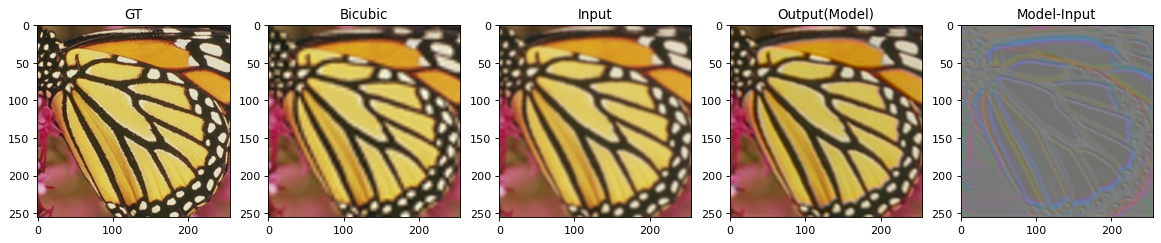

In [64]:
display_PSNR(im_gt, im_b, im_b2, model, channels=1);


In [65]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(height/scale), int(width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = Crappify(crop_size = None, kernel_size=scale*2, quality=90)(im_gt)# open image file
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 



psnr for bicubic is 33.390163695766894dB
psnr for input is 32.689178632208844dB
psnr for Model is 28.516338527108008dB
PSNR improvement is -4.1728401051008355dB
Sharpness Measurement GroundTruth: 247.28295878820063
Sharpness Measurement Bicubic: 9.535258178118966
Sharpness Measurement Input: 8.645674942003097
Sharpness Measurement Model: 33.3346783122397


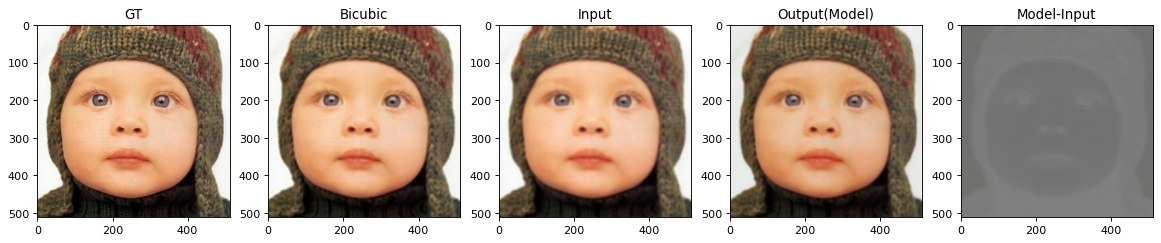

RuntimeError: The size of tensor a (29) must match the size of tensor b (28) at non-singleton dimension 3

In [66]:
test_results("/media/SSD/superres/video_data/test_data/Set5", 4, channels = 1,display = True)

# convert sample videos

In [67]:
result_path

PosixPath('/media/SSD/superres/Results/Superresolution train MWCNN')

In [68]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-16.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 1/900 [00:00<01:36,  9.27it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train MWCNN/muffins30sec-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [01:35<00:00,  9.40it/s]


True

In [69]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 5/900 [00:00<00:19, 46.70it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train MWCNN/muffins30sec-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:17<00:00, 50.99it/s]


True

In [70]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 1/900 [00:00<01:37,  9.26it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train MWCNN/muffins30sec-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [01:55<00:00,  7.77it/s]


True

In [71]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model,channels=1, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train MWCNN/muffins30sec-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [03:05<00:00,  4.84it/s]


True

In [72]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [73]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [74]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [75]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train MWCNN/super8.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [10:11<00:00, 11.76it/s]


True

In [76]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [77]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [78]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8hresperfuzmodel2.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [79]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [80]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = str(result_path/"super8long.mp4")
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model,channels=1, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 1/121409 [00:00<3:47:43,  8.89it/s]

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train MWCNN/super8long.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [2:34:18<00:00, 13.11it/s] 


True

In [81]:
# Above will error out since channels is set to 3....

In [82]:
dualfile= str(result_path/"super8longdual.mp4")
infile = str(infile)
outfile = str(outfile)

In [83]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su